In [1]:
import copy
import datetime as dt
import importlib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pathlib
import sys
import time
import pickle
from typing import Union
import warnings
from datetime import datetime
from pyswarm import pso  # Install with: pip install pyswarm
warnings.filterwarnings("ignore")
from info_grupos import empirical_vars_to_avoid, frac_vars_special_cases_list
from utilities.utils import HelperFunctions, SSPModelForCalibration, SectoralDiffReport, NonEnergySectoralDiffReport, ErrorFunctions
import logging
from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples

In [2]:
# Initialize helper functions
helper_functions = HelperFunctions()

In [3]:
# Paths
SRC_FILE_PATH = os.getcwd()
build_path = lambda PATH: os.path.abspath(os.path.join(*PATH))
DATA_PATH = build_path([SRC_FILE_PATH, "..", "data"])
OUTPUT_PATH = build_path([SRC_FILE_PATH, "..", "output"])
REAL_DATA_FILE_PATH = build_path([DATA_PATH, "real_data.csv"])
MISC_FILES_PATH = build_path([SRC_FILE_PATH, 'misc'])
OPT_CONFIG_FILES_PATH = build_path([SRC_FILE_PATH, 'config'])
OPT_OUTPUT_PATH = build_path([SRC_FILE_PATH,"..", "output"])

In [4]:
# Set up important params
target_region = 'croatia'
iso_alpha_3 = 'HRV'
error_type = 'rmse'
unique_id = 20250102104421

In [5]:
# Load input dataset
examples = SISEPUEDEExamples()
cr = examples("input_data_frame")

df_input = pd.read_csv(REAL_DATA_FILE_PATH)
df_input = df_input.rename(columns={'period': 'time_period'})
df_input = helper_functions.add_missing_cols(cr, df_input.copy())
df_input = df_input.drop(columns='iso_code3')

# Columns to scale
columns_all_999 = df_input.columns[(df_input == -999).any()].tolist()
pij_cols = [col for col in df_input.columns if col.startswith('pij')]
cols_to_avoid = pij_cols + frac_vars_special_cases_list + columns_all_999 + empirical_vars_to_avoid
cols_to_stress = helper_functions.get_indicators_col_names(df_input, cols_with_issue=cols_to_avoid)

In [15]:
# TODO: Import the opt_results df
opt_results_df = pd.read_csv(build_path([OPT_OUTPUT_PATH, f"opt_results_{target_region}_{unique_id}.csv"]))

# Get the best scaling vector from the opt_results_df
best_scaling_vector = opt_results_df.iloc[opt_results_df['Error'].idxmin()][2:].values

# Ensure best_scaling_vector is float
best_scaling_vector = np.array([float(i) for i in best_scaling_vector])

best_scaling_vector

array([4.01324208e-04, 1.79998211e+00, 1.77227124e+00, ...,
       1.80000000e+00, 1.79825222e+00, 1.63116467e+00])

In [ ]:
# Scale the columns
stressed_df = df_input.copy()
stressed_df[cols_to_stress] = df_input[cols_to_stress] * best_scaling_vector

# Normalize fractional columns
normalized_stressed_df = helper_functions.normalize_frac_vars(stressed_df, cols_to_avoid, MISC_FILES_PATH)

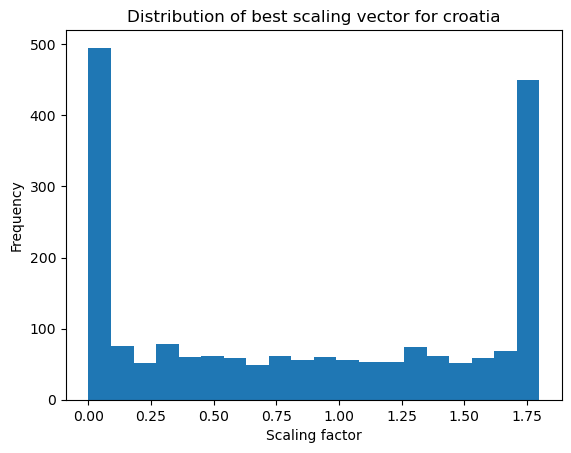

In [17]:
# Plot distribution of best scaling vector
plt.figure()
plt.hist(best_scaling_vector, bins=20)
plt.title(f"Distribution of best scaling vector for {target_region}")
plt.xlabel("Scaling factor")
plt.ylabel("Frequency")
plt.show()

In [18]:
ssp_model = SSPModelForCalibration()
diff_report_helpers = NonEnergySectoralDiffReport(MISC_FILES_PATH, iso_alpha_3, init_year=2015)

2025-01-09 09:41:35,535 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-01-09 09:41:35,538 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-01-09 09:41:35,538 - INFO - 	Setting export engine to 'csv'.
2025-01-09 09:41:35,539 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-01-09 09:41:35,541 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-01-09 09:41:35,542 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-01-09 09:41:35,543 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-01-09 09:41:35,544 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-01-09 09:41:35,545 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-01-09 09:41:35,546 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   3166.6 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-01-09 09:42:42,936 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-01-09 09:42:42,962 - INFO - Successfully initialized SISEPUEDEModels.
2025-01-09 09:42:42,973 - INFO - Table ANALYSIS_METADATA successfully written to /home/tony-ubuntu/anaconda3/envs/ssp_env/lib/python3.11

In [19]:
sim_output_df = ssp_model.run_ssp_simulation(normalized_stressed_df)

2025-01-09 09:43:32,090 - INFO - Running AFOLU model
2025-01-09 09:43:32,260 - INFO - AFOLU model run successfully completed
2025-01-09 09:43:32,261 - INFO - Running CircularEconomy model
2025-01-09 09:43:32,319 - INFO - CircularEconomy model run successfully completed
2025-01-09 09:43:32,320 - INFO - Running IPPU model
2025-01-09 09:43:32,394 - INFO - IPPU model run successfully completed
2025-01-09 09:43:32,394 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-01-09 09:43:32,417 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-01-09 09:43:32,505 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-01-09 09:43:32,506 - INFO - Running Energy (Fugitive Emissions)
2025-01-09 09:43:32,533 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-01-09 09:43:32,533 - INFO - Appe

In [20]:
detailed_diff_report, subsector_diff_report = diff_report_helpers.generate_diff_reports(simulation_df=sim_output_df)

All variables from Vars are present in simulation_df.


In [21]:
detailed_diff_report

,Year,Subsector,Edgar_Class,Simulation_Values,Edgar_Values,diff
0,2015,agrc,AG - Crops:CH4,0.395663,0.000227,1744.768282
1,2015,agrc,AG - Crops:CO2,0.070609,0.095857,-0.263393
2,2015,agrc,AG - Crops:N2O,0.506047,1.038055,-0.512505
3,2015,frst,LULUCF - Forest Land:CH4,0.223256,NaN,NaN
4,2015,frst,LULUCF - Forest Land:CO2,-1.934118,-6.547104,-0.704584
5,2015,ippu,IN - Industrial Processes:CH4,0.005715,0.001673,2.415879
6,2015,ippu,IN - Industrial Processes:CO2,1.963502,2.415891,-0.187256
7,2015,ippu,IN - Industrial Processes:HFC,1.631643,0.514149,2.173481
8,2015,ippu,IN - Industrial Processes:N2O,0.018240,0.946129,-0.980722
9,2015,ippu,IN - Industrial Processes:PFC,0.000016,0.000000,inf


In [22]:
subsector_diff_report

,Year,Subsector,Simulation_Values,Edgar_Values,diff
0,2015,agrc,0.972319,1.134139,-0.142681
1,2015,frst,-1.710862,-6.547104,-0.738684
2,2015,ippu,3.619115,3.883217,-0.068011
3,2015,lndu,0.553715,0.060840,8.101236
4,2015,lsmm,0.762128,1.793108,-0.574968
5,2015,lvst,1.708291,1.682916,0.015078
6,2015,soil,3.960236,0.092259,41.924982
7,2015,trww,0.041421,0.503173,-0.917681
8,2015,waso,1.611594,1.258690,0.280375


In [23]:
subsector_diff_report['diff_percentage'] = subsector_diff_report['diff'] * 100

In [24]:
subsector_diff_report

,Year,Subsector,Simulation_Values,Edgar_Values,diff,diff_percentage
0,2015,agrc,0.972319,1.134139,-0.142681,-14.268124
1,2015,frst,-1.710862,-6.547104,-0.738684,-73.868422
2,2015,ippu,3.619115,3.883217,-0.068011,-6.801123
3,2015,lndu,0.553715,0.060840,8.101236,810.123617
4,2015,lsmm,0.762128,1.793108,-0.574968,-57.496842
5,2015,lvst,1.708291,1.682916,0.015078,1.507826
6,2015,soil,3.960236,0.092259,41.924982,4192.498185
7,2015,trww,0.041421,0.503173,-0.917681,-91.768116
8,2015,waso,1.611594,1.258690,0.280375,28.037484


In [25]:
normalized_stressed_df.to_csv(f'../croatia_input_data_stressed_{unique_id}.csv', index=False)